# FIFA World Ranking

For those not familiar with FIFA world ranking and its acutal reputation: FIFA world ranking for men had been introduced in December 1992. From August 1993 onwards it has been published regularly on the [FIFA World Ranking](https://www.fifa.com/fifa-world-ranking/ranking-table/men). The duration between release of new tables also differs. Clearly it will be interesting to find out which team was on top the longest, how far was a big drop among the top teams, do we have teams which dominate years or one of the three decades (analogous what you would do with other sports rankings).

While it has been used for seeding purposes in Qualifiers and FIFA World Cup groups, unlike other rankings it still has a rather dubious reputation among fans or the general public. Comments are given that it has certain biases, or doesn't reflect the true strength of teams, at least once one goes to the lower portions of the table, but also on the top 50 teams. 

Long term plan: We could in fact investigate how good the ranking works as predictor for success in important championships. Clearly anything can happen in one match, but overall in a tournament where many games are played, I would hope if the FIFA World Ranking is a good reflection of performances, then this will be reflected in outcomes of tournaments too. For that we would need to merge the available data here with other data on performances, where I would check: FIFA World Cups, Copa Americana, and the UEFA European Championships. 

One notable case which I would expect to find which came as one of the biggest surprise in the past years since I follow football, should be Greece's win of the UEFA European Championship in 2000.

In [1]:
import requests
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

# this is a fancy progress bar! works on jupyter notebook
from tqdm.notebook import tqdm

from time import sleep
import datetime

In [2]:
link = "https://www.fifa.com/fifa-world-ranking/ranking-table/men/"
response = requests.get(link, timeout=5)  # add timeout for the request
print(response.status_code)
#<ul class="fi-ranking-schedule__nav dropdown-menu"
#here we should find all the drop down menu with links to all separate tables

200


In [6]:
soup = BeautifulSoup(response.content, "html.parser")

In [183]:
#soup.find("a").text
all_a = soup.findAll("a")  # .find_all("a")

In [8]:
all_dates = soup.find('ul',{'class': 'fi-ranking-schedule__nav dropdown-menu'})
                        
id_list =[]
date_list=[]

for i in tqdm(range(len(all_dates.findAll('a')))):
    id_list.append(all_dates.findAll('li')[i].get('data-value'))
#id list works
    
for i in tqdm(range(len(all_dates.findAll('a')))):
    date=all_dates.findAll('a')[i].get_text()
    #format of date is at the moment day month name year
    date_time = datetime.datetime.strptime(date, "%d %B %Y")
    date_list.append(date_time)
    
if len(id_list)!= len(date_list):
    print("conceptually both lists should be of same length, check why this is not the case ",len(id_list),len(date_list))

Now we have all dates and corresponding ID's saved to load all historical data. Per ranking we safe the ranking spot, the points, the previous points, the movement in ranks with respect to the previous ranking, and the date. Since the world ranking is not released always that regularly, maybe we have to treat the distance between the timestamps separately too. 

In [9]:
urlpattern = "https://www.fifa.com/fifa-world-ranking/ranking-table/men/"

#id in listid is added at the end of this link
#keep track of dates which have a one to one correspondance as well

def scrape_one_table(id_value,date_value):
    """
    scrapes FIFA world cup data, given the overall urlpattern from above
    a id_value is required provided by the drop down menu
    date value according to the release date of the table
    
    output is a dataframe containing:
    ranking,country, points, previous points, move in the ranking, and conference
    """
    
    url = urlpattern+id_value
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    try:
        ranking = soup.find_all("td", {"class": "fi-table__td fi-table__rank"})
        ranking = [item.get_text().strip() for item in ranking]
    except:
        ranking=[]

    try:
        country = soup.find_all("span", {"class": "fi-t__nText"})
        country = [item.get_text().strip() for item in country]
    except:
        county=[]
    try:
        points = soup.find_all("td", {"class": "fi-table__td fi-table__points"})
        points = [item.get_text().strip() for item in points]
    except:
        points=[]
    try:
        prev_points = soup.find_all("td", {"class": "fi-table__td fi-table__prevpoints"})
        prev_points = [item.get_text().strip() for item in prev_points]
    except:
        prev_points=[]
        
    try:
        move = soup.find_all("td", {"class": "fi-table__td fi-table__rankingmovement"})
        move = [item.get_text().strip() for item in move]
    except:
        move=[]
        
    try:
        conf = soup.find_all("td", {"class": "fi-table__td fi-table__confederation hidden"})
        conf = [item.get_text().strip() for item in conf]
    except:
        conf=[]
    #originally had a typo which made conf not appear at all
    #print("lenght of all entries",len(ranking),len(country),len(points),len(prev_points),len(move),len(conf))
    
        #Create datafame for link
    df = pd.DataFrame({
                    "ranking": ranking,
                    "country": country,
                    "points": points,
                    "prev_points": prev_points,
                    "move": move,
                    "conf": conf
                })
    df["date"] = date_value
    return df

In [10]:
urlpattern = "https://www.fifa.com/fifa-world-ranking/ranking-table/men/rank/"
#id in listid is added at the end of this link, keep track of dates which have a one to one correspondance as well
# lets check if our scraper works
check = scrape_one_table(id_list[0],date_list[0])
check.head()

,ranking,country,points,prev_points,move,conf,date
0,1,Belgium,1773,1765,0,#UEFA#,2020-09-17
1,2,France,1744,1733,0,#UEFA#,2020-09-17
2,3,Brazil,1712,1712,0,#CONMEBOL#,2020-09-17
3,4,England,1664,1661,0,#UEFA#,2020-09-17
4,5,Portugal,1653,1639,2,#UEFA#,2020-09-17


In [11]:
columns = check.columns.values
combined_df = pd.DataFrame(columns=columns)

counter = 0

for i in tqdm(range(len(id_list))):
    temp_df = scrape_one_table(id_list[i],date_list[i])
    combined_df = combined_df.append(temp_df)
    #don't stress the system with too many requests
    if i%5==0:
        sleep(0.6)  
    counter += 1
    
    if counter == len(date_list):
        print("Scraping Completed")

KeyboardInterrupt: 

In [74]:
#save the scraped data
combined_df.to_csv('FIFAWorldRankings.csv', encoding='utf-8', index=False)
with open('FIFAWorldRankings.json', 'w') as f:
    f.write(combined_df.to_json(orient='records', lines=True))

## Playing with data

Data has been prepared, for some columns I still have to figure out how to handle special values. These are for example - in case of a non existing previous ranking. Some teams entered FIFA late, since countries or confederations have been created after the ranking existed, think e.g. of all EX-Yugoslavian countries. Otherwise entries from outside the top 200 can happen as well. For these we don't have proper handling ensured at the moment.

In [3]:
#read the data from the csv file
df= pd.read_csv('FIFAWorldRankings.csv')
df.head()

,ranking,country,points,prev_points,move,conf,date
0,1,Belgium,1773,1765.0,0,#UEFA#,2020-09-17
1,2,France,1744,1733.0,0,#UEFA#,2020-09-17
2,3,Brazil,1712,1712.0,0,#CONMEBOL#,2020-09-17
3,4,England,1664,1661.0,0,#UEFA#,2020-09-17
4,5,Portugal,1653,1639.0,2,#UEFA#,2020-09-17


In [79]:
df.dtypes
#here we also see the existing issue that the move has values which are non numeric from "outside" of the table

ranking          int64
country         object
points           int64
prev_points    float64
move            object
conf            object
date            object
dtype: object

In [4]:
df["date"]=pd.to_datetime(df["date"],format="%Y-%m-%d")
print(df.dtypes)
df.head()

ranking                 int64
country                object
points                  int64
prev_points           float64
move                   object
conf                   object
date           datetime64[ns]
dtype: object


,ranking,country,points,prev_points,move,conf,date
0,1,Belgium,1773,1765.0,0,#UEFA#,2020-09-17
1,2,France,1744,1733.0,0,#UEFA#,2020-09-17
2,3,Brazil,1712,1712.0,0,#CONMEBOL#,2020-09-17
3,4,England,1664,1661.0,0,#UEFA#,2020-09-17
4,5,Portugal,1653,1639.0,2,#UEFA#,2020-09-17


__Question 1__: 

How many confederations appeared in the FIFA ranking: 223. The number of confederations at the moment is 211 (in fact this is what is shown as highest value in the ranking itself), thus we had at least 22 confederations which ceased to exist at some point.

In [14]:
len(df['country'].unique().tolist())

223

In [32]:
new_df=df[(df["date"]!="1992-12-31") & (df["prev_points"].isna()) & (df["points"].notna())].sort_values(by="prev_points").tail(65)
new_confederations=new_df["country"]
print(new_confederations)

24907    Sao Tome e Principe
31564             Montenegro
32800                Comoros
32997            Timor-Leste
33653                 Serbia
                ...         
61605                Vietnam
61614                   Laos
61628         Cayman Islands
61633              Sri Lanka
61639                  Macau
Name: country, Length: 65, dtype: object


In [86]:
df.sort_values(by="ranking",ascending=False)

,ranking,country,points,prev_points,move,conf,date
2311,211,San Marino,839,848.0,0,#UEFA#,2019-06-14
3999,211,Tonga,774,774.0,0,#OFC#,2018-07-01
2100,211,San Marino,839,839.0,0,#UEFA#,2019-07-25
2522,211,San Marino,848,854.0,0,#UEFA#,2019-04-04
2733,211,San Marino,854,854.0,0,#UEFA#,2019-02-07
...,...,...,...,...,...,...,...
37088,1,Brazil,842,843.0,0,#CONMEBOL#,2005-01-19
36884,1,Brazil,840,842.0,0,#CONMEBOL#,2005-02-16
5266,1,Germany,1602,1602.0,0,#UEFA#,2017-12-21
36680,1,Brazil,836,840.0,0,#CONMEBOL#,2005-03-23


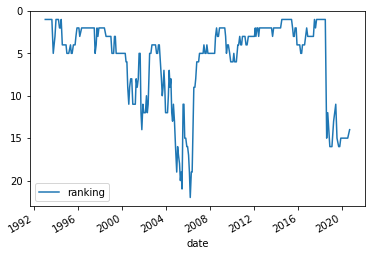

In [5]:
df[df["country"]=="Germany"].plot(x='date', y='ranking').invert_yaxis()

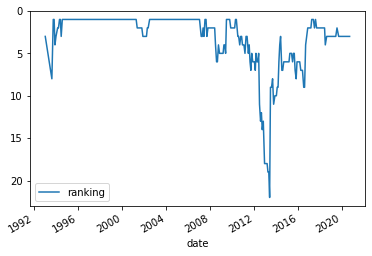

In [47]:
df[df["country"]=="Brazil"].plot(x='date', y='ranking').invert_yaxis()

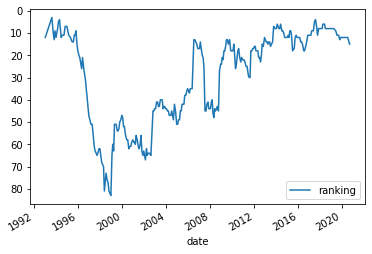

In [48]:
df[df["country"]=="Switzerland"].plot(x='date', y='ranking').invert_yaxis()

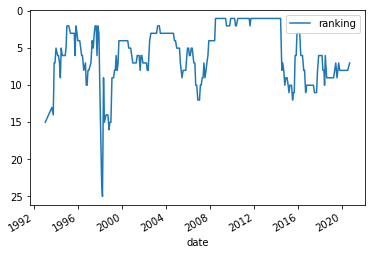

In [49]:
df[df["country"]=="Spain"].plot(x='date', y='ranking').invert_yaxis()

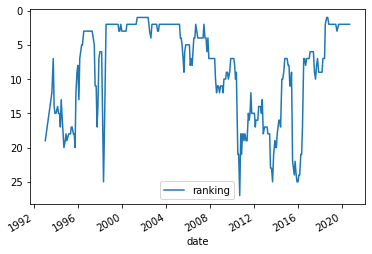

In [50]:
df[df["country"]=="France"].plot(x='date', y='ranking').invert_yaxis()

__Question 2__:

How many teams have claimed the top spot in the ranking, and for how long?

In [114]:
#check first how many countries we have, seems it is 8
df[df["ranking"]==1].groupby("country").count().shape

df[df["ranking"]==1].groupby("country").count().nlargest(8,"conf",)

,ranking,points,prev_points,move,conf,date
country,,,,,,
Brazil,143,143,143,143,143,143
Spain,64,64,64,64,64,64
Germany,30,30,29,30,30,30
Argentina,26,26,26,26,26,26
Belgium,22,22,22,22,22,22
France,15,15,15,15,15,15
Italy,6,6,6,6,6,6
Netherlands,1,1,1,1,1,1


__Answer 2__:
    
This comes as a suprise to me, not really for the top 4, but that France had only 15 weeks in the lead is surprising to me. Particularly considering within this timeframe France won the UEFA European Championship once, and the worldcup twice. Italy only lead the ranking 6 times, considering they had been world champion in 2006 and reached the final in the European Championship of 2012 this comes as a surprise to me too.

Brazil was clearly the dominating team of the last 30 years, having won the FIFA World Cup title in 1994, 2002 and having reached the final in 1998, in fact Brazil alone has been leading the ranking longer than ll european teams combined. Then again we have two FIFA World Cup titles vs four FIFA world cup titles won by UEFA teams, so maybe something is biased within the ranking system as well.

In [116]:
df[df["ranking"]==1].groupby("conf").count()

,ranking,country,points,prev_points,move,date
conf,,,,,,
#CONMEBOL#,169,169,169,169,169,169
#UEFA#,138,138,138,137,138,138


In [120]:
df.groupby("conf").size()

conf
#AFC#         13522
#CAF#         15939
#CONCACAF#    10202
#CONMEBOL#     3060
#OFC#          3050
#UEFA#        16031
dtype: int64

__Question 3__:
    
What was the best rank for any team of each confederation, we know for UEFA and CONMEBOL the answer is Rank 1, but what about the other four confederations. Some confederations have also considerably less member countries.

In [127]:
#check first how many countries we have, seems it is 8
#df.groupby("conf").sort_values(by=["ranking","country"])
df.sort_values(by=["conf","ranking"]).groupby("conf").head(3)

,ranking,country,points,prev_points,move,conf,date
53192,9,Japan,59,59.0,0,#AFC#,1998-03-18
53383,9,Japan,59,58.0,5,#AFC#,1998-02-18
53003,11,Japan,58,59.0,-2,#AFC#,1998-04-22
60311,5,Nigeria,56,50.0,13,#CAF#,1994-04-19
60143,7,Nigeria,55,56.0,-2,#CAF#,1994-05-17
22842,9,Egypt,1078,1047.0,1,#CAF#,2010-12-15
33826,4,Mexico,758,758.0,2,#CONCACAF#,2006-05-17
34030,4,USA,760,764.0,1,#CONCACAF#,2006-04-19
38519,4,Mexico,735,738.0,2,#CONCACAF#,2004-06-09
6110,1,Brazil,1604,1603.0,1,#CONMEBOL#,2017-08-10


__Answer:__
    
CONCACAF (Northern and Central American teams) made it as high as number 4, a bit ridiculous, considering the USA never made it beyond the quarter finals, Nigeria hit number 5, once again none of the African teams made it beyond the quarters as well, the best rank of any OCC team had been reached by Australia with 31, but Australia switched later. Of the current OCC team New Zealand did reach 47 as best ranking.

In [141]:
datetime_cutoff=datetime.datetime(2006,1,1)
print(datetime_cutoff)
df[(df["country"]=="Australia") & (df["date"]<datetime_cutoff)].sort_values(by=["ranking"])

2006-01-01 00:00:00


,ranking,country,points,prev_points,move,conf,date
54551,31,Australia,51,50.0,2,#AFC#,1997-07-16
52833,32,Australia,52,52.0,1,#AFC#,1998-05-20
53788,32,Australia,53,53.0,1,#AFC#,1997-11-19
54361,32,Australia,51,51.0,-1,#AFC#,1997-08-20
53980,33,Australia,53,51.0,3,#AFC#,1997-10-17
...,...,...,...,...,...,...,...
48317,89,Australia,433,440.0,-6,#AFC#,2000-05-10
38808,89,Australia,486,491.0,-3,#AFC#,2004-05-12
49122,90,Australia,410,410.0,-1,#AFC#,2000-01-19
48922,91,Australia,408,410.0,-1,#AFC#,2000-02-16


Australia moved from OCC to AFC on Jan 1, 2006

__Questions:__

- Which country had most points ever?
- Which was the smallest point difference between Rank 1 and Rank 2?
- Which was the largest point difference between Rank 1 and Rank 2?
- Which was the largest point loss/gain by any team ever?

In [34]:
df.sort_values(by=["points"],ascending=False).head(3)

,ranking,country,points,prev_points,move,conf,date
3789,1,Germany,2172,2187.0,0,#UEFA#,2018-07-01
3790,2,France,2164,2134.0,2,#UEFA#,2018-07-01
3791,3,Portugal,2163,2155.0,-1,#UEFA#,2018-07-01


Most points ever: Oh the Irony, here we have Germany going into the world cup of 2018, dropping out in the group stage.

In [40]:
df["point_diff"]=df["prev_points"]-df["points"]
df.sort_values(by=["point_diff"],ascending=False).head(3)

,ranking,country,points,prev_points,move,conf,date,point_diff
32218,36,Nigeria,690,1244.0,-27,#CAF#,2007-02-14,554.0
32244,62,Guinea,495,881.0,-40,#CAF#,2007-02-14,386.0
11362,2,Germany,1411,1775.0,1,#UEFA#,2015-07-09,364.0


Largest point increase has been observed for Nigeria

In [42]:
df["point_diff"]=df["prev_points"]-df["points"]
df.sort_values(by=["point_diff"],ascending=True).head(3)

,ranking,country,points,prev_points,move,conf,date,point_diff
33619,2,Italy,1550,728.0,11,#UEFA#,2006-07-12,-822.0
33618,1,Brazil,1630,827.0,0,#CONMEBOL#,2006-07-12,-803.0
51441,1,Brazil,829,73.0,0,#CONMEBOL#,1999-01-27,-756.0


Once again we observe the largest point drop by Italy, also Brazil ahead of the world cup of 2006. Ironically Italy went on to win this worldcup.

In [61]:
df_sel_r12=df[df["ranking"]<3]
df_sel_r12=df[df["ranking"]<3]
print(df_sel_r12.head(30))
difference = df_sel_r12["points"].diff()
difference.sort().head(30)


      ranking  country  points  prev_points move        conf       date  \
0           1  Belgium    1773       1765.0    0      #UEFA# 2020-09-17   
1           2   France    1744       1733.0    0      #UEFA# 2020-09-17   
210         1  Belgium    1765       1765.0    0      #UEFA# 2020-07-16   
211         2   France    1733       1733.0    0      #UEFA# 2020-07-16   
420         1  Belgium    1765       1765.0    0      #UEFA# 2020-06-11   
421         2   France    1733       1733.0    0      #UEFA# 2020-06-11   
630         1  Belgium    1765       1765.0    0      #UEFA# 2020-04-09   
631         2   France    1733       1733.0    0      #UEFA# 2020-04-09   
840         1  Belgium    1765       1765.0    0      #UEFA# 2020-02-20   
841         2   France    1733       1733.0    0      #UEFA# 2020-02-20   
1050        1  Belgium    1765       1765.0    0      #UEFA# 2019-12-19   
1051        2   France    1733       1733.0    0      #UEFA# 2019-12-19   
1260        1  Belgium   

AttributeError: 'Series' object has no attribute 'sort'

__Question:__ 
    
What had been the biggest drop from No 1, or the largest ascent to No 1

__Answer:__
The largest jump had been made in early times of the ranking by Brasil, I didn't find anything particular what happend here, besides the fact that the points limit was very low, so seems rather biased. The second point on this list is a huge jump for France moving from 7 to 1. This reflects the large point increase due to their win in the FIFA world cup of 2018.

Oh and sadly the largest drop from No 1 goes to Germany for their catastrophic performanc in the 2018 worldcup as well down to No 15.

In [143]:
df[df["ranking"]==1].sort_values(by=["move"],ascending=False)

,ranking,country,points,prev_points,move,conf,date
61309,1,Brazil,59,54.0,7,#CONMEBOL#,1993-09-23
3578,1,France,1726,1576.0,6,#UEFA#,2018-08-16
26150,1,Brazil,1672,1288.0,4,#CONMEBOL#,2009-07-01
28643,1,Spain,1557,1303.0,3,#UEFA#,2008-07-02
11361,1,Argentina,1473,1496.0,2,#CONMEBOL#,2015-07-09
...,...,...,...,...,...,...,...
23456,1,Spain,1824,1883.0,0,#UEFA#,2010-09-15
23663,1,Spain,1883,1883.0,0,#UEFA#,2010-08-11
24078,1,Brazil,1611,1611.0,0,#CONMEBOL#,2010-05-26
24493,1,Spain,1602,1642.0,0,#UEFA#,2010-03-31


In [148]:
df["move"]=pd.to_numeric(df["move"], errors='coerce')
print(df.dtypes)
df.head()
df[(df["ranking"]+df["move"])==1].sort_values(by=["ranking"],ascending=False)

ranking                 int64
country                object
points                  int64
prev_points           float64
move                  float64
conf                   object
date           datetime64[ns]
dtype: object


,ranking,country,points,prev_points,move,conf,date
3592,15,Germany,1561,1600.0,-14.0,#UEFA#,2018-08-16
13876,8,Spain,1229,1485.0,-7.0,#UEFA#,2014-07-17
28648,6,Argentina,1298,1559.0,-5.0,#CONMEBOL#,2008-07-02
61314,5,Germany,56,58.0,-4.0,#UEFA#,1993-09-23
59796,4,Germany,61,60.0,-3.0,#UEFA#,1994-07-21
...,...,...,...,...,...,...,...
23249,1,Spain,1881,1824.0,0.0,#UEFA#,2010-10-20
23456,1,Spain,1824,1883.0,0.0,#UEFA#,2010-09-15
23663,1,Spain,1883,1883.0,0.0,#UEFA#,2010-08-11
24078,1,Brazil,1611,1611.0,0.0,#CONMEBOL#,2010-05-26


In [152]:
df[(df['ranking']<11) & ((df["ranking"]+df["move"])>10)].sort_values(by=["move"],ascending=False)

,ranking,country,points,prev_points,move,conf,date
57858,10,Nigeria,56,43.0,24.0,#CAF#,1995-09-19
53189,6,Netherlands,60,55.0,19.0,#UEFA#,1998-03-18
21596,9,Mexico,1007,802.0,19.0,#CONCACAF#,2011-06-29
52618,8,Netherlands,64,54.0,17.0,#UEFA#,1998-07-15
3581,4,Croatia,1643,1528.0,16.0,#UEFA#,2018-08-16
...,...,...,...,...,...,...,...
14714,10,Belgium,1084,1117.0,1.0,#UEFA#,2014-03-13
54912,10,Russia,59,58.0,1.0,#UEFA#,1997-05-14
14087,10,England,1090,1043.0,1.0,#UEFA#,2014-06-05
56411,10,Denmark,56,55.0,1.0,#UEFA#,1996-07-03


In [153]:
df[(df['ranking']>10) & ((df["ranking"]+df["move"])<11)].sort_values(by=["move"],ascending=True)

,ranking,country,points,prev_points,move,conf,date
8639,205,Gibraltar,0,0.0,-205.0,#UEFA#,2016-09-15
18874,199,South Sudan,20,0.0,-199.0,#CAF#,2012-08-08
9041,190,Kosovo,66,0.0,-190.0,#UEFA#,2016-07-14
32218,36,Nigeria,690,1244.0,-27.0,#CAF#,2007-02-14
57704,35,Nigeria,43,56.0,-25.0,#CAF#,1995-10-17
...,...,...,...,...,...,...,...
50852,11,Romania,700,697.0,-1.0,#UEFA#,1999-04-21
50651,11,England,695,700.0,-1.0,#UEFA#,1999-05-19
12207,11,Spain,1130,1144.0,-1.0,#UEFA#,2015-03-12
52040,11,Mexico,62,62.0,-1.0,#CONCACAF#,1998-10-21


__Question:__

What had been the biggest climb into top 10, and biggest drop out of top 10


__Answer:__

The biggest climb happened to Nigeria back in 1995, ignoring the newly created teams, it was once again Nigeria who experienced the largest drop, this time in 2007.

In [154]:
print(df[df["ranking"]<4].groupby("country").count().nlargest(10,"conf",))

                ranking  points  prev_points  move  conf  date
country                                                       
Brazil              223     223          222   222   223   223
Germany             136     136          135   135   136   136
Spain               115     115          115   115   115   115
Argentina           111     111          111   111   111   111
France              109     109          109   109   109   109
Netherlands          53      53           53    53    53    53
Italy                46      46           45    45    46    46
Belgium              39      39           39    39    39    39
Czech Republic       30      30           30    30    30    30
Portugal             13      13           13    13    13    13


In [155]:
print(df[df["ranking"]<6].groupby("country").count().nlargest(10,"conf",))

                ranking  points  prev_points  move  conf  date
country                                                       
Brazil              252     252          251   251   252   252
Germany             217     217          216   216   217   217
Argentina           175     175          175   175   175   175
Spain               156     156          156   156   156   156
France              134     134          134   134   134   134
Italy                99      99           98    98    99    99
Netherlands          97      97           97    97    97    97
Belgium              63      63           63    63    63    63
Czech Republic       58      58           58    58    58    58
Portugal             53      53           53    53    53    53


In [156]:
print(df[df["ranking"]<11].groupby("country").count().nlargest(10,"conf",))

                ranking  points  prev_points  move  conf  date
country                                                       
Brazil              293     293          292   292   293   293
Spain               282     282          282   282   282   282
Argentina           279     279          278   278   279   279
Germany             249     249          248   248   249   249
Netherlands         219     219          218   218   219   219
France              205     205          205   205   205   205
Portugal            194     194          194   194   194   194
Italy               185     185          184   184   185   185
England             171     171          170   170   171   171
Czech Republic      116     116          116   116   116   116


In [174]:
df_mean_count=df.groupby("country").agg({'ranking': ['mean','median']})
list(df_mean_count.columns) 
df.groupby("country").agg({'ranking': ['mean','median']}).sort_values(by=('ranking', 'mean')).head(30)

ranking       
                          mean median
country                              
Brazil                3.163399    2.0
Spain                 5.529412    5.0
Germany               5.640523    4.0
Argentina             5.751634    5.0
France                8.555556    7.0
Italy                 8.784314    9.0
Netherlands           9.241830    8.0
England              10.258170   10.0
Portugal             11.098039    8.0
Mexico               14.705882   15.0
Czechoslovakia       18.166667   18.5
Denmark              19.803922   17.0
Colombia             19.941176   17.0
Czech Republic       19.946488   15.0
USA                  20.620915   22.0
Croatia              20.950980   16.0
Sweden               21.869281   19.5
Uruguay              22.068627   20.0
Romania              23.990196   22.5
Russia               24.375817   23.0
Belgium              28.464052   27.0
Switzerland          29.977124   21.0
Greece               30.026144   31.5
Turkey               30.124183   30.0
Chile                30.568627   23.0
Republic of Ireland  32.343137   32.5
Norway               32.676471   29.0
Serbia               33.441718   33.0
Paraguay             34.395425   30.0
Japan                35.160131   35.0

__Question__: 

Which are the 10 best teams of all time?

Answer:

Independent of our definition in terms of weeks spent in higher ranks (defined by top3, top5 or top 10),Brazil, Germany are the top 2, Argentina   Spain, France, Italy, and Netherlands are part of top 10. If we consider low ranks Portugal, the Czech Republic and Belgium join. But Belgium had not been part of top 10 for a long time, then England would make it instead. 

If we consider the average ranking of all time, not restricting ourselves to top 10, then Mexico would be in top 10, Germany would drop to 3rd place due to Spain being on average better ranked. Belgium drops considerably to the level of Switzerland (and Greece, which did win a big title in fact, but so did Chile)

In [200]:
#seems UEFA has it in a better format for automatation (see below)
link_uefa="https://www.uefa.com/uefaeuro/history/seasons/2016/matches/"
response_uefa = requests.get(link_uefa, timeout=15)  # add timeout for the request
print(response.status_code)
soup_uefa = BeautifulSoup(response_uefa.content, "html.parser")

200


In [219]:
year_uefa = soup_uefa.find_all("div", {"class": "season-year"})
year_uefa = [item.get_text().strip() for item in year_uefa]

round_uefa=soup_uefa.find_all("h3", {"class": "round-title match-round js__show-only-first"})
round_uefa = [item.get_text().strip() for item in round_uefa]

year=year_uefa[0]

#add year to date which lists only day, month
date_uefa=soup_uefa.find_all("h3", {"class": "matches-match_date hide"})
date_uefa = [item.get_text().strip()+" "+year for item in date_uefa]
date_time_uefa = [datetime.datetime.strptime(date_point, "%d %b %Y") for date_point in date_uefa]
print(date_time_uefa)
#date_uefa list day, month


match_comment_uefa = soup_uefa.find_all("div", {"class": "js-match-status-rw match-status-rw"})
match_comment_uefa = [item.get_text().strip() for item in match_comment_uefa]

home_team_uefa = soup_uefa.find_all("div", {"class": "team-home"})
home_team_uefa = [item.get_text().strip() for item in home_team_uefa]

away_team_uefa = soup_uefa.find_all("div", {"class": "team-away"})
away_team_uefa = [item.get_text().strip() for item in away_team_uefa]

home_score_uefa = soup_uefa.find_all("span", {"class": "js-team--home-score home-score"})
home_score_uefa = [item.get_text().strip() for item in home_score_uefa]

away_score_uefa = soup_uefa.find_all("span", {"class": "js-team--away-score away-score"})
away_score_uefa = [item.get_text().strip() for item in away_score_uefa]
print(away_score_uefa)

#comments are listed twice, so try to get rid of each second of those
match_comment_filled=[match_comment_uefa[i] for i in range(0,len(match_comment_uefa),2)]
#print(match_comment_filled,len(match_comment_filled))
print("row length",len(date_time_uefa),len(round_uefa),len(home_team_uefa),len(away_team_uefa),
      len(home_score_uefa),len(away_score_uefa),len(match_comment_filled))
df = pd.DataFrame({
        "date": date_time_uefa,
        "round": round_uefa,
        "home_team": home_team_uefa,
        "away_team": away_team_uefa,
        "home_score": home_score_uefa,
        "away_score": away_score_uefa,
        "score_comment": match_comment_filled
                })
df["year"]=year
df.head()
"""
   df = pd.DataFrame({
                    "ranking": ranking,
                    "country": country,
                    "points": points,
                    "prev_points": prev_points,
                    "move": move,
                    "conf": conf
                })
    df["date"] = date_value
    return df
"""

"""
    ranking = soup.find_all("td", {"class": "fi-table__td fi-table__rank"})
        ranking = [item.get_text().strip() for item in ranking]
    except:
        ranking=[]

    try:
        country = soup.find_all("span", {"class": "fi-t__nText"})
        country = [item.get_text().strip() for item in country]
    except:
        county=[]
    try:
        points = soup.find_all("td", {"class": "fi-table__td fi-table__points"})
        points = [item.get_text().strip() for item in points]
    except:
        points=[]
    try:
        prev_points = soup.find_all("td", {"class": "fi-table__td fi-table__prevpoints"})
        prev_points = [item.get_text().strip() for item in prev_points]
    except:
        prev_points=[]
        
    try:
        move = soup.find_all("td", {"class": "fi-table__td fi-table__rankingmovement"})
        move = [item.get_text().strip() for item in move]
    except:
        move=[]
        
    try:
        conf = soup.find_all("td", {"class": "fi-table__td fi-table__confederation hidden"})
        conf = [item.get_text().strip() for item in conf]
    except:
        conf=[]
    #originally had a typo which made conf not appear at all
    #print("lenght of all entries",len(ranking),len(country),len(points),len(prev_points),len(move),len(conf))
    
        #Create datafame for link
    df = pd.DataFrame({
                    "ranking": ranking,
                    "country": country,
                    "points": points,
                    "prev_points": prev_points,
                    "move": move,
                    "conf": conf
                })
    df["date"] = date_value
    return df
"""

[datetime.datetime(2016, 7, 10, 0, 0), datetime.datetime(2016, 7, 7, 0, 0), datetime.datetime(2016, 7, 6, 0, 0), datetime.datetime(2016, 7, 3, 0, 0), datetime.datetime(2016, 7, 2, 0, 0), datetime.datetime(2016, 7, 1, 0, 0), datetime.datetime(2016, 6, 30, 0, 0), datetime.datetime(2016, 6, 27, 0, 0), datetime.datetime(2016, 6, 27, 0, 0), datetime.datetime(2016, 6, 26, 0, 0), datetime.datetime(2016, 6, 26, 0, 0), datetime.datetime(2016, 6, 26, 0, 0), datetime.datetime(2016, 6, 25, 0, 0), datetime.datetime(2016, 6, 25, 0, 0), datetime.datetime(2016, 6, 25, 0, 0), datetime.datetime(2016, 6, 22, 0, 0), datetime.datetime(2016, 6, 22, 0, 0), datetime.datetime(2016, 6, 22, 0, 0), datetime.datetime(2016, 6, 22, 0, 0), datetime.datetime(2016, 6, 21, 0, 0), datetime.datetime(2016, 6, 21, 0, 0), datetime.datetime(2016, 6, 21, 0, 0), datetime.datetime(2016, 6, 21, 0, 0), datetime.datetime(2016, 6, 20, 0, 0), datetime.datetime(2016, 6, 20, 0, 0), datetime.datetime(2016, 6, 19, 0, 0), datetime.datetim

ValueError: arrays must all be same length